In [1]:
from __future__ import division

import lal
import lalsimulation as lalsim
import pycbc.frame
from pycbc.psd import welch, interpolate
from pycbc.filter import highpass_fir, resample_to_delta_t, sigmasq

import os, sys
import numpy as np
import scipy.stats as sts
import scipy.optimize as opt
from mpmath import quad, inf, exp, pi
from fitter import Fitter
import h5py, pycwt, pickle

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['ytick.labelsize'] = 15

from calndm import FindNonDimensionalFrequency
import utils
mUtils = utils.MiscellaneousUtils()


def mask_coi(Power, freqs, coi):
    periods = 1 / freqs
    for i in range(Power.shape[1]):
        mask = periods > coi[i]
        Power[mask, i] = float('NaN')
    return Power

In [2]:
mUtils.approx = 'NR_hdf5'
mUtils.nr_hdf5_filepath = "/home/sebastian.khan/ligo-nr-data/lvcnr-lfs/SXS/SXS_BBH_0294_Res3.h5"
mUtils.fmin = 25.0
mUtils.tref = 4.0
mUtils.det = "L1"
mUtils.mass1 = 36.662310665079644
mUtils.mass2 = 10.475005235539586
mUtils.iota = 0.9
mUtils.psi = 2.433232307434082
mUtils.theta = -1.1653016805648804
mUtils.phi = 1.2109811305999756
#mUtils.det_event_time = 1126259462.0

mUtils.cwt_fhigh= 600.0
mUtils.alpha_arr = np.linspace(0.2, 2.9, 541)

In [3]:
# Generate the waveform including all the modes
mUtils.mode_list = None
wf = mUtils._gen_waveform()
wf = pycbc.types.TimeSeries(wf.data.data[:], delta_t=wf.deltaT)


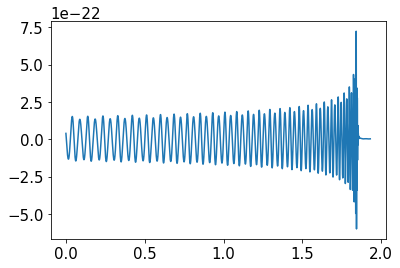

In [4]:
plt.plot(wf.sample_times, wf.data)

In [5]:
print mUtils.fmin, mUtils.spin1x, mUtils.spin1y, mUtils.spin1z, mUtils.spin2x, mUtils.spin2y, mUtils.spin2z

20.000000000000004 -8.83532945064e-11 1.07023685419e-11 4.06354937484e-09 -3.22049337507e-12 1.49979064524e-11 2.01582365971e-07


### Resize the waveform and the coalescence time tref=4.0

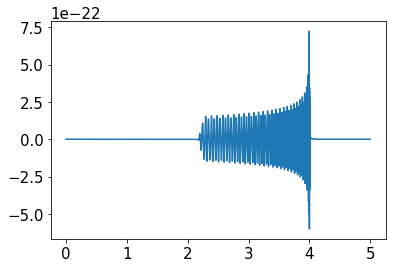

In [6]:
mUtils.mode_list = [(2, 2), (2, -2)]
h22 = mUtils._gen_waveform()
h22 = pycbc.types.TimeSeries(h22.data.data[:], delta_t=h22.deltaT)

mUtils.mode_list = [(3, 3), (3, -3)]
h33 = mUtils._gen_waveform()
h33 = pycbc.types.TimeSeries(h33.data.data[:], delta_t=h33.deltaT)

mUtils.mode_list = [(4, 4), (4, -4)]
h44 = mUtils._gen_waveform()
h44 = pycbc.types.TimeSeries(h44.data.data[:], delta_t=h44.deltaT)


length = int(1.0/mUtils.deltaF/mUtils.deltaT)
h22.resize( length )
h33.resize( length )
h44.resize( length )
wf.resize( length )

wf.data *= lal.CreateTukeyREAL4Window(length, 0.05).data.data[:]
h22.data *= lal.CreateTukeyREAL4Window(length, 0.05).data.data[:]
h33.data *= lal.CreateTukeyREAL4Window(length, 0.05).data.data[:]
h44.data *= lal.CreateTukeyREAL4Window(length, 0.05).data.data[:]

# Set the peak index at self.tref
peak_indx = h22.abs_arg_max()
col_indx = int( mUtils.tref/mUtils.deltaT)
shift_indx = col_indx-peak_indx
wf.roll(shift_indx)
h22.roll(shift_indx)
h33.roll(shift_indx)
h44.roll(shift_indx)

plt.plot(wf.sample_times, wf.data)


#### Choose a event time
The event time of S190412m is 1239082262. We inject the NR waveform after 100s.

In [7]:
mUtils.event_time = 1239082262.18 + 64.0
mUtils.det_event_time = 1239082262.18 + 64.0

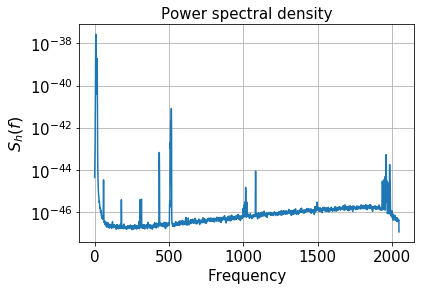

In [8]:
# Loading the gravitational wave starin
half_length = 32
raw_strain = pycbc.frame.query_and_read_frame("L1_HOFT_C00", "L1:GDS-CALIB_STRAIN", \
        int(mUtils.det_event_time - half_length), int(mUtils.det_event_time + half_length))
L1 = resample_to_delta_t(raw_strain, mUtils.deltaT)

# Compute PSD
psdL1 = interpolate(welch(L1), 1.0 / L1.duration)
# 
psd = interpolate(welch(L1), mUtils.deltaF)

fig, ax = plt.subplots(figsize=(6, 4))
ax.semilogy(psdL1.sample_frequencies, psdL1.data)
ax.set_xlabel("Frequency", fontsize=15)
ax.set_ylabel(r"$S_h(f)$", fontsize=16)
ax.set_title("Power spectral density", fontsize=15)
ax.grid(True)

In [9]:
raw_strain.sample_times[0]

1239082294.0

In [10]:
print "Optimal SNR of Full HOM:", sigmasq(wf, psd=psd, low_frequency_cutoff=20)**0.5
print "Optimal SNR of Full h22:", sigmasq(h22, psd=psd, low_frequency_cutoff=20)**0.5
print "Optimal SNR of Full HOM:", sigmasq(h33, psd=psd, low_frequency_cutoff=20)**0.5

Optimal SNR of Full HOM: 24.930609572018273
Optimal SNR of Full h22: 24.35461930203797
Optimal SNR of Full HOM: 5.67308188667254


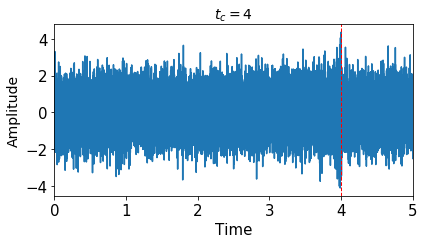

In [11]:
# Whiten the waveforms
wwf = mUtils._whiten(wf, psd)
wh22 = mUtils._whiten(h22, psd)
wh33 = mUtils._whiten(h33, psd)
wh44 = mUtils._whiten(h44, psd)

# Inject the whiten waveform in the whiten data
wtseries = mUtils._whiten(L1, psdL1)

start = mUtils.det_event_time - int(mUtils.det_event_time) + half_length - mUtils.tref
sidx = int(  start/mUtils.deltaT)
eidx = int( (start + 1/mUtils.deltaF)/mUtils.deltaT)
# Add the whiten waveform
wstrain = pycbc.types.TimeSeries(wtseries.data[sidx:eidx]+wwf.data, delta_t=mUtils.deltaT)

fig, ax = plt.subplots(figsize=(6, 3.5))
ax.plot(wstrain.sample_times, wstrain.data)
ax.axvline(x=4, ls='--', lw=1.0, color='r')
ax.set_xlim(0, 5)
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel('Amplitude', fontsize=14)
ax.set_title(r"$t_c = 4$", fontsize=14)
plt.tight_layout()


### Find the optimized nondiemnsional frequency of the Morlet wavelet

In [12]:
fSchwarzISCO = 1.0 / ( 6.0**1.5 * lal.PI * (mUtils.mass1 + mUtils.mass2) * lal.MTSUN_SI )
mUtils.track_end_frequency = 0.6*fSchwarzISCO
#ndmf = FindNonDimensionalFrequency(mUtils, wstrain.data, track_length=1.0)
#mUtils.ndm_freq = ndmf
#print ndmf
mUtils.ndm_freq = 14.931428373380939 
# for fISCO: 12.258527064819752

#### Generate the $22-$track

In [13]:
tArrFixDT, fArrFixDT, tArrFixDF, fArrFixDF = mUtils._gen_time_frequency_path(start_freq=15.0, \
                                track_max_length=0.5, track_end_frequency=0.6*fSchwarzISCO)

In [14]:
# Generate the time-frequency map
wave, scales, freqs, coi = mUtils._compute_cwt(wstrain.data)[:4]
power = np.abs(wave)**2.0

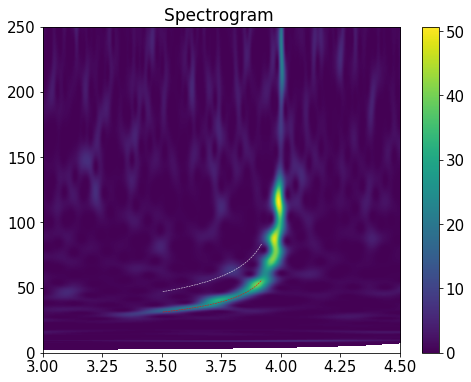

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.imshow( mask_coi(power, freqs, coi) , extent=[0.0, 1.0/mUtils.deltaF, freqs.min(), freqs.max()],\
           aspect='auto', origin='lower')
plt.title("Spectrogram ", fontsize=17)
plt.plot(tArrFixDT, fArrFixDT, ls='--', c='r', lw=0.5)
plt.plot(tArrFixDT, 1.5*fArrFixDT, ls='--', c='white', lw=0.5)
plt.ylim(0.0, 250)
plt.xlim(3.0, 4.5)
plt.colorbar()

In [16]:
mUtils.alpha_arr = np.linspace(0.2, 2.9, 541)
Yalpha = mUtils._stack_pixels_energies(power, tArrFixDT, fArrFixDT, tArrFixDF, fArrFixDF)

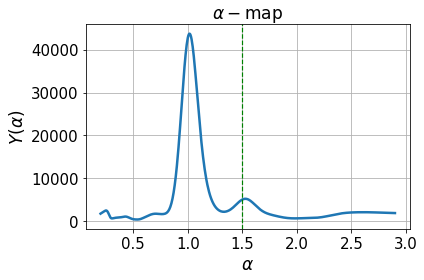

In [17]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(mUtils.alpha_arr, Yalpha, lw=2.5)
ax.axvline(x=1.5, ls='--', c='g', lw=1.2)

ax.set_xlabel(r"$\alpha$", fontsize=17)
ax.set_ylabel(r"$Y(\alpha)$", fontsize=17)
ax.set_title(r"$\alpha-$map", fontsize=17)
ax.grid(True)
plt.tight_layout()

### Extraction of the higher order modes using the SEOBNRv4 template

In [18]:
mUtils.approx = 'SEOBNRv4HM'
# Set the case for aligned spin waveform only
mUtils.spin1x, mUtils.spin1y, mUtils.spin2x, mUtils.spin2y = 0.0, 0.0, 0.0, 0.0
# Generate the template model by considering the specific modes
mUtils.mode_list = [(2, 2)]
Salpha22 = mUtils._gen_template_model( psd, tArrFixDT, fArrFixDT, tArrFixDF, fArrFixDF)[0]

mUtils.mode_list = [ (3, 3)]
Salpha33 = mUtils._gen_template_model(psd, tArrFixDT, fArrFixDT, tArrFixDF, fArrFixDF)[0]

mUtils.mode_list = [ (4, 4)]
Salpha44 = mUtils._gen_template_model( psd, tArrFixDT, fArrFixDT, tArrFixDF, fArrFixDF)[0]


In [20]:
with open('nalpha_samples.pickle', 'rb') as handle:
    nalpha_dic = pickle.load(handle)

keys = nalpha_dic.keys()
keys.sort()
Nalpha_dataFull = np.vstack(( nalpha_dic[key] for key in keys ))

idxx = np.unique(np.hstack(( np.where( np.max(Nalpha_dataFull, axis=1) >100000 )[0], \
                            np.where( np.max(Nalpha_dataFull[:, :60], axis=1) >10000 )[0], \
                           np.where( Nalpha_dataFull[:,0] >2500 )[0] )))

Nalpha_dataFull = np.delete(Nalpha_dataFull, idxx, axis=0)

# Compute the covariance matrix using 2400 Nalpha samples, and
# remaining samples are used to compute p(\beta | H_0)
midIdx = Nalpha_dataFull.shape[0]//2
deltaIdx = 1200
Nalpha_data = Nalpha_dataFull.copy()[midIdx-deltaIdx:midIdx+deltaIdx]

# Mean of N(\alpha)
mualpha = np.mean(Nalpha_data, axis=0)

# Compute the covariance matrix of N(\alpha)
# \Sigma(\alpha, \alpha') = E[ (N(alpha) -\mu(a\lpha)) (N(\alpha')-\mu(\alpha'))^T ]
xy = np.vstack([Nalpha_data[:,j] - mualpha[j] for j in range(len(mualpha))])
npcov = np.cov(xy)

# FIXME: The tracks with alpha<0.5 may belong to the low-frequency region of the TF-map.
# Few of the 'Nalpha' samples are very high at alpha<0.5 due to the high noise at low frequencies.
# Therefore, we estimate the statistics value, assuming the region of alpha>0.5.
delta_alpha = mUtils.alpha_arr[1] - mUtils.alpha_arr[0]
if mUtils.alpha_arr[0]<0.5:
    str_idx = int( (0.5 - mUtils.alpha_arr[0])/delta_alpha)
else:
    str_idx = 0
npcov = npcov[str_idx:, str_idx:]
# Reduced yalpha and Salpha
Yalpha_r   = Yalpha[str_idx:]
Salpha22_r = Salpha22[str_idx:]
Salpha33_r = Salpha33[str_idx:]
Salpha44_r = Salpha44[str_idx:]
mualpha_r  = mualpha[str_idx:]

# Inverse of covariance matrix
covinv = np.linalg.inv(npcov)

In [21]:
# Maximize the LLR for signal model m=2 mode.
initial_guess = [1.0]
res22 = opt.minimize(utils.NegativeLogLikelihoodRatio, initial_guess, args=[ [Salpha22_r], \
                Yalpha_r, covinv, mualpha_r], method='Powell', options={'ftol': 1e-20} )

# Maximize the LLR for m=2 and m=3 modes.
initial_guess = [1.0, 1.0]
res22_33 = opt.minimize(utils.NegativeLogLikelihoodRatio, initial_guess, args=[ [Salpha22_r, Salpha33_r], \
                Yalpha_r, covinv, mualpha_r], method='Powell', options={'ftol': 1e-20} )

# Maximize the LLR for m=2, m=3 and m=4 modes.
initial_guess = [1.0, 1.0, 1.0]
res22_33_44 = opt.minimize(utils.NegativeLogLikelihoodRatio, initial_guess, args=[ [Salpha22_r, Salpha33_r, Salpha44_r], \
                Yalpha_r, covinv, mualpha_r], method='Powell', options={'ftol': 1e-20} )

# Compute the final statistic \beta
sArr33 = res22_33.x[1]*Salpha33_r
gammasq33 = np.dot( sArr33, np.dot(covinv, sArr33) )
beta33 = (-res22_33.fun + res22.fun + 0.5*gammasq33)/gammasq33**0.5


sArr44 = res22_33_44.x[2]*Salpha44_r
gammasq44 = np.dot( sArr44, np.dot(covinv, sArr44) )
beta44 = (-res22_33_44.fun + res22_33.fun + 0.5*gammasq44)/gammasq44**0.5

In [22]:
idx2 = np.array( range(midIdx-deltaIdx) + range(midIdx+deltaIdx, Nalpha_dataFull.shape[0]) )
betaList33, betaList44 = [], []
for ii in idx2:
    nArr = Nalpha_dataFull[ii][str_idx:] - mualpha_r
    b33 = np.dot( nArr, np.dot(covinv, sArr33) )/gammasq33**0.5
    b44 = np.dot( nArr, np.dot(covinv, sArr44) )/gammasq44**0.5
    betaList33.append( b33 )
    betaList44.append( b44 )
betaList33 = np.array(betaList33)
betaList44 = np.array(betaList44)

# Fit the emperical distribution of p(\beta | H_0) with a Gaussian distribution
loc33, scale33 = sts.norm.fit(betaList33)
loc44, scale44 = sts.norm.fit(betaList44)

# Calulate p-value by integrating p(\beta | H_0) from event \beta to infinity.
pvalue33 = quad(lambda x: (1.0/(2.0*np.pi*scale33**2)**0.5)*exp(-(x-loc33)**2/(2.0*scale33**2.0)), [beta33, np.inf])
sys.stdout.write("LLR(22)= %1.2f \nLLR(22+33)= %1.2f, beta(33)= %1.2f, p-value= %g \n" % \
                 (-res22.fun, -res22_33.fun, beta33, pvalue33))

pvalue44 = quad(lambda x: (1.0/(2.0*np.pi*scale44**2)**0.5)*exp(-(x-loc44)**2/(2.0*scale44**2.0)), [beta44, np.inf])
sys.stdout.write("LLR(22+33+44)=%1.2f, beta(44)= %1.2f, p-value= %g \n"%(-res22_33_44.fun, beta44, pvalue44))


LLR(22)= 4835.42 
LLR(22+33)= 4886.20, beta(33)= 10.08, p-value= 5.99123e-13 
LLR(22+33+44)=4886.36, beta(44)= 0.60, p-value= 0.397268 


### Extraction of the higher order modes using the NR template

In [34]:
mUtils.approx = 'NR_hdf5'
# Set the case for aligned spin waveform only
mUtils.spin1x, mUtils.spin1y, mUtils.spin2x, mUtils.spin2y = 0.0, 0.0, 0.0, 0.0
# Generate the template model by considering the specific modes
mUtils.mode_list = [(2, 2), (2, -2)]
Salpha22nr = mUtils._gen_template_model( psd, tArrFixDT, fArrFixDT, tArrFixDF, fArrFixDF)[0]

mUtils.mode_list = [ (3, 3), (3, -3)]
Salpha33nr = mUtils._gen_template_model(psd, tArrFixDT, fArrFixDT, tArrFixDF, fArrFixDF)[0]

mUtils.mode_list = [ (4, 4), (4, -4)]
Salpha44nr = mUtils._gen_template_model( psd, tArrFixDT, fArrFixDT, tArrFixDF, fArrFixDF)[0]

Salpha22nr_r = Salpha22nr[str_idx:]
Salpha33nr_r = Salpha33nr[str_idx:]
Salpha44nr_r = Salpha44nr[str_idx:]
mualphanr_r  = mualpha[str_idx:]

# Maximize the LLR for signal model m=2 mode.
initial_guess = [1.0]
res22 = opt.minimize(utils.NegativeLogLikelihoodRatio, initial_guess, args=[ [Salpha22nr_r], \
                Yalpha_r, covinv, mualpha_r], method='Powell', options={'ftol': 1e-20} )

# Maximize the LLR for m=2 and m=3 modes.
initial_guess = [1.0, 1.0]
res22_33 = opt.minimize(utils.NegativeLogLikelihoodRatio, initial_guess, args=[ [Salpha22nr_r, Salpha33nr_r], \
                Yalpha_r, covinv, mualpha_r], method='Powell', options={'ftol': 1e-20} )

# Maximize the LLR for m=2, m=3 and m=4 modes.
initial_guess = [1.0, 1.0, 1.0]
res22_33_44 = opt.minimize(utils.NegativeLogLikelihoodRatio, initial_guess, args=[ [Salpha22nr_r, Salpha33nr_r, Salpha44nr_r], \
                Yalpha_r, covinv, mualpha_r], method='Powell', options={'ftol': 1e-20} )

# Compute the final statistic \beta
sArr33 = res22_33.x[1]*Salpha33nr_r
gammasq33 = np.dot( sArr33, np.dot(covinv, sArr33) )
beta33 = (-res22_33.fun + res22.fun + 0.5*gammasq33)/gammasq33**0.5

sArr44 = res22_33_44.x[2]*Salpha44nr_r
gammasq44 = np.dot( sArr44, np.dot(covinv, sArr44) )
beta44 = (-res22_33_44.fun + res22_33.fun + 0.5*gammasq44)/gammasq44**0.5

In [25]:
idx2 = np.array( range(midIdx-deltaIdx) + range(midIdx+deltaIdx, Nalpha_dataFull.shape[0]) )
betaList33, betaList44 = [], []
for ii in idx2:
    nArr = Nalpha_dataFull[ii][str_idx:] - mualpha_r
    b33 = np.dot( nArr, np.dot(covinv, sArr33) )/gammasq33**0.5
    b44 = np.dot( nArr, np.dot(covinv, sArr44) )/gammasq44**0.5
    betaList33.append( b33 )
    betaList44.append( b44 )
betaList33 = np.array(betaList33)
betaList44 = np.array(betaList44)

# Fit the emperical distribution of p(\beta | H_0) with a Gaussian distribution
loc33, scale33 = sts.norm.fit(betaList33)
loc44, scale44 = sts.norm.fit(betaList44)

# Calulate p-value by integrating p(\beta | H_0) from event \beta to infinity.
pvalue33 = quad(lambda x: (1.0/(2.0*np.pi*scale33**2)**0.5)*exp(-(x-loc33)**2/(2.0*scale33**2.0)), [beta33, np.inf])
sys.stdout.write("LLR(22)= %1.2f \nLLR(22+33)= %1.2f, beta(33)= %1.2f, p-value= %g \n" % \
                 (-res22.fun, -res22_33.fun, beta33, pvalue33))

pvalue44 = quad(lambda x: (1.0/(2.0*np.pi*scale44**2)**0.5)*exp(-(x-loc44)**2/(2.0*scale44**2.0)), [beta44, np.inf])
sys.stdout.write("LLR(22+33+44)=%1.2f, beta(44)= %1.2f, p-value= %g \n"%(-res22_33_44.fun, beta44, pvalue44))


LLR(22)= 4851.07 
LLR(22+33)= 4901.86, beta(33)= 10.08, p-value= 6.00041e-13 
LLR(22+33+44)=4901.93, beta(44)= 0.37, p-value= 0.456852 
